In [1]:
import torch
import os
import os.path as osp
import numpy as np
import tqdm
import pandas as pd
from pydicom import dcmread

In [2]:
threshold = 0.75
stride = 32
patch_size = 64
save_root = '/home/zzhuang/Codes/denoising/dataset/piglet'

def crop(ds):
    patches = []
    for left in range(0, ds.shape[0] - patch_size + 1, stride):
        for top in range(0, ds.shape[1] - patch_size + 1, stride):
            patches.append(ds[left: left + patch_size, top: top + patch_size])
    return patches

fulldose_root = '/home/zzhuang/DATASET/CT/piglet_share/DICOM/PA0/ST0/SE4'
# 25%
# lowdose_root = '/home/zzhuang/DATASET/CT/piglet_share/DICOM/PA0/ST0/SE14'

# 5%
lowdose_root = '/home/zzhuang/DATASET/CT/piglet_share/DICOM/PA0/ST0/SE24'

test_indices = np.array(list(range(21, 871, 6)))
train_indices = np.array([x for x in range(21, 871) if x not in test_indices])
all_indices = {'train': train_indices, 'test': test_indices}

In [3]:
def get_file_list(path):
    file_list = []
    name_list = []
    for name in sorted(os.listdir(path)):
        file_list.append(osp.join(path, name))
        name_list.append(int(name.strip('IM')))
    file_list = np.array(file_list)
    name_list = np.array(name_list)
    file_list = file_list[np.argsort(name_list)]
    return file_list
fulldose_ct_list = get_file_list(fulldose_root)
lowdose_ct_list = get_file_list(lowdose_root)
# C021, C120 ...
for phase in ['train', 'test']:
# for phase in ['test']:
    indices = all_indices[phase]
    patches = []
    phase_fulldose_ct_list, phase_lowdose_ct_list = fulldose_ct_list[indices], lowdose_ct_list[indices]
    for i in tqdm.trange(len(phase_fulldose_ct_list)):
        a, b = phase_fulldose_ct_list[i], phase_lowdose_ct_list[i]
        f_ps = crop(dcmread(a).pixel_array.astype(np.float32))
        l_ps = crop(dcmread(b).pixel_array.astype(np.float32))
        for k in range(len(f_ps)):
            black_percent = np.mean(np.clip(f_ps[k] - 1024, -500, 500) == -500)
            if black_percent < threshold:
                patches.append(np.array([l_ps[k], f_ps[k]]))
    patches = np.array(patches).reshape((-1, 2, 1, patch_size, patch_size)).transpose((1, 0, 2, 3, 4))
    print('save data...')
    np.save(osp.join(save_root, '{}_{}'.format(phase, patch_size)), patches.astype(np.uint16))


100%|██████████| 142/142 [00:01<00:00, 74.49it/s]


save data...
save data...


In [4]:
patches.shape

(2, 12023, 1, 64, 64)

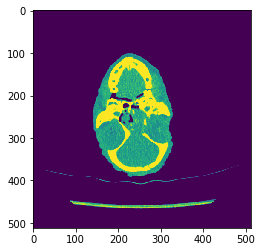

In [11]:
import matplotlib.pyplot as plt
index = 0
plt.imshow(np.clip(patches[0, index, 0] - 1024, -300, 300))

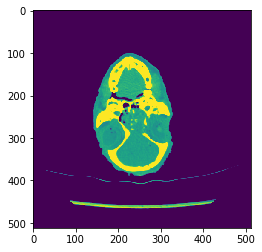

In [12]:
plt.imshow(np.clip(patches[1, index, 0] - 1024, -300, 300))

In [9]:
for phase in ['train', 'test']:
# for phase in ['test']:
    indices = all_indices[phase]
    patches = []
    phase_fulldose_ct_list, phase_lowdose_ct_list = fulldose_ct_list[indices], lowdose_ct_list[indices]
    for i in tqdm.trange(len(phase_fulldose_ct_list)):
        a, b = phase_fulldose_ct_list[i], phase_lowdose_ct_list[i]
        f_ps = dcmread(a).pixel_array
        l_ps = dcmread(b).pixel_array
        patches.append(np.array([l_ps, f_ps]))
    patches = np.array(patches).reshape((-1, 2, 1, f_ps.shape[0], f_ps.shape[1])).transpose((1, 0, 2, 3, 4))
    print('save data...')
    np.save(osp.join(save_root, '{}_{}'.format(phase, 512)), patches.astype(np.uint16))

100%|██████████| 142/142 [00:00<00:00, 200.97it/s]


save data...
save data...


In [10]:
patches.shape

(2, 142, 1, 512, 512)